<a href="https://colab.research.google.com/github/2003UJAN/VGG-Net-16-Architecture/blob/main/VGGNet_16_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vgg16:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6302%2F9896%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T070447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D41953c62b234e87acd9429770b9225217756e4ec2d7970c7a1514a2c390ed0ecf5c9eeeba6c9690e261966fd84194c3a0bf7650bd5e207ef67c450529882a53963a918edc1548d993bff02f6200668c77dad644b2a6148ba78d0819bca9e5283ee3f5c4a3f4f97630f82ae642a3ae43d43d53e2e7fe2feedf316893e9e5b1e9ce49e0e2083ee7d949eeb6c7fc28237ee614a7c52457f7a408ca1759df981b613b08d2ec66521fbea18ec61ca130b100d11c93cba32efc55732c13a1a0f758f41cb8d1f54c0917d580422f21dfc6316777f1921be3a20263a0a819d3bffc0b8b6345d64329fe988616a6b6bd691a04a55f50d35b809806c8dad7a9cb1d54b094c,flowers-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8782%2F2431805%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T070447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D89453a0652621732aa5223d37e7882e88dc74c49a202ac5c01b01864d7050ebfc5e8e561975004a11918d7fc220ac0f6b20cd3f9836650073bc2ac46e0a1e4e662851effb2a4b4681414a310533ddaade95d41f3ef93461c1ad1cb95c8f3a757d86d3f0ab18dfc3f3945bf036f98bf641a2507b113ced60466a963578918b2926ff2087545f028f9e097401fe0fe321bcc0d7955dbe2836c59639580c8baba6c136ca510b0010028f03b6331250436a45969c176ef723d42bd084fd32e2a51c9ed46b63207bdbce036b30ea4191708da233cfe67c847fc6ddd101150e63e1a459e422269bdc7225c7c514535e1be0ce2f59c75fd75fbe829c5e8cfc36e1d0680'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 568472495 bytes downloaded
Downloaded and uncompressed: vgg16
[==================================================] 235663188 bytes downloaded
Downloaded and uncompressed: flowers-recognition
Data source import complete.


## VGG-16 Code Implementation

### Importing Libraries

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

### Defining input image shape

In [3]:
_input = Input((224,224,1))

### Building a VGG-16 model

In [4]:
conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(1000, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

In [5]:
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

img1 = "../input/flowers-recognition/flowers/tulip/10094729603_eeca3f2cb6.jpg"
img2 = "../input/flowers-recognition/flowers/dandelion/10477378514_9ffbcec4cf_m.jpg"
img3 = "../input/flowers-recognition/flowers/sunflower/10386540696_0a95ee53a8_n.jpg"
img4 = "../input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg"
imgs = [img1, img2, img3, img4]

def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def _get_predictions(_model):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))
    plt.show()

    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(_model.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()

### Using pretrained weights to save some time.

<ipython-input-5-2dad3c2fa52b>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))


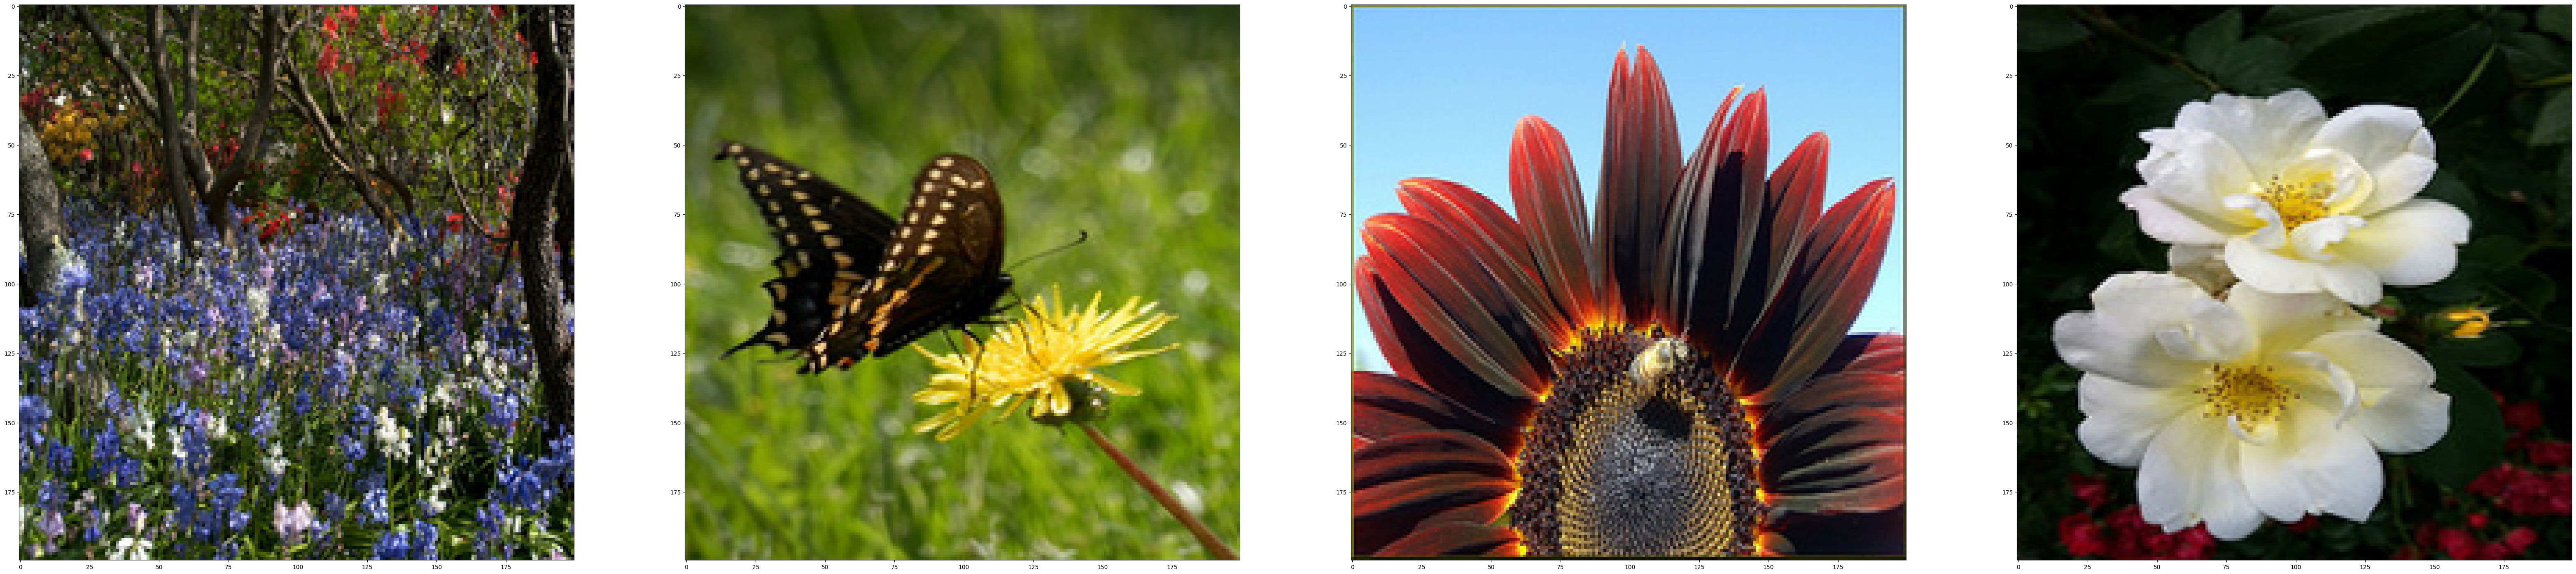

1/1 [==============================] - 1s 579ms/step


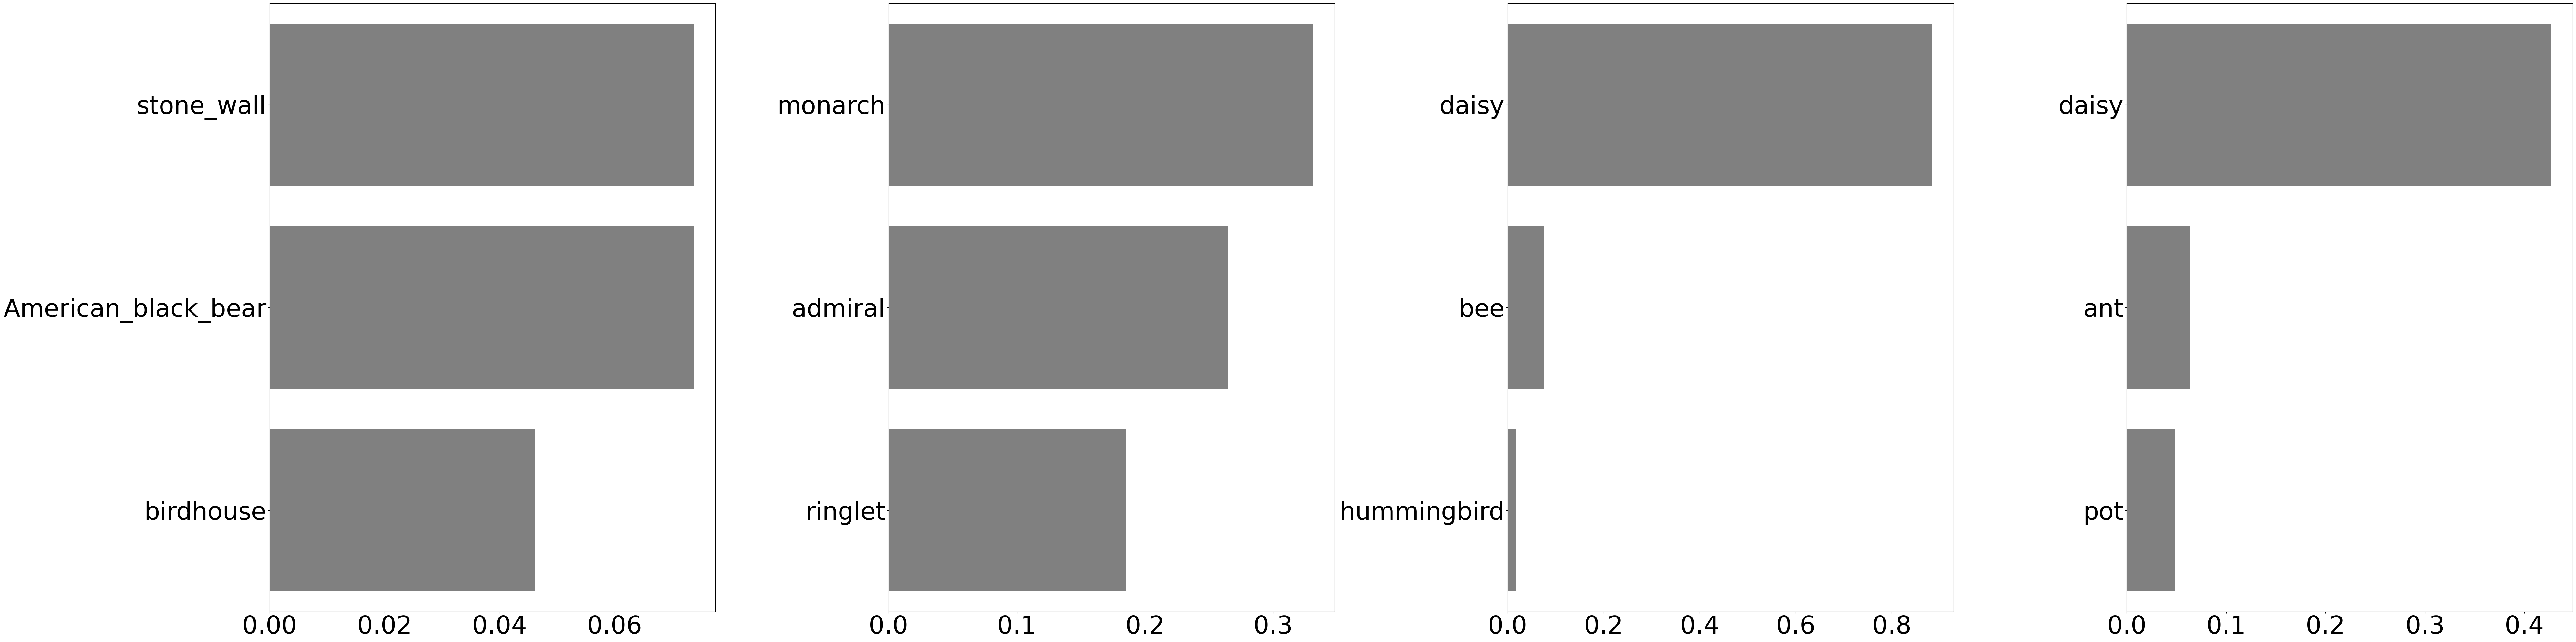

In [6]:
from keras.applications.vgg16 import VGG16
vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
_get_predictions(vgg16_model)